<a href="https://colab.research.google.com/github/nikhil-1e9/toxic-content-detection/blob/main/toxic_content_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets praw --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 5.4 MB/s eta 0:00:00


In [ ]:
import opendatasets as od

In [ ]:
od.download("https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nikhil1e9
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset


100%|██████████| 2.21M/2.21M [00:00<00:00, 2.75MB/s]

## Imports

In [ ]:
import re
import praw
import torch
import nltk
import numpy as np
import pandas as pd
import opendatasets as od
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertForSequenceClassification, BertTokenizer, TextClassificationPipeline

In [ ]:
# Function to clean the text and remove stopwords
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and # from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    # Remove stopwords
    # text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

In [ ]:
# Load the pretrained BERT model and tokenizer for embeddings
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.eval()

# Helper function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)

    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:713: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92     26084
           1       0.95      0.82      0.88     19312

    accuracy                           0.91     45396
   macro avg       0.91      0.89      0.90     45396
weighted avg       0.91      0.91      0.90     45396



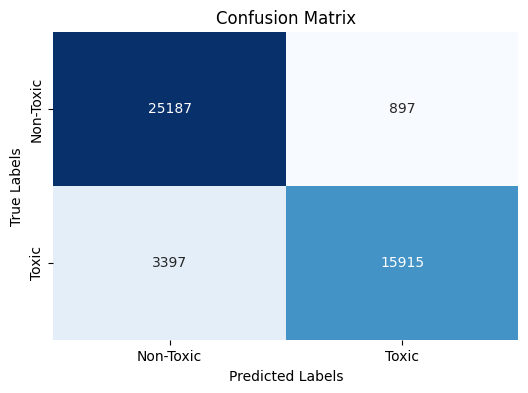

In [ ]:
train_data, test_data = train_test_split(data,
                                         test_size=0.95,
                                         random_state=67)

# Initialize the vectorizer and the classifier
vectorizer = TfidfVectorizer(stop_words='english')
# Fit the vectorizer on the training data
vectorizer.fit(train_data['tweet'])

# Function to simulate streaming data
def simulate_data_stream(data, batch_size=100):
    num_samples = len(data)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        yield data.iloc[start_idx:end_idx]

# Simulate data stream for training
clf = PassiveAggressiveClassifier(C=0.1, loss='hinge', max_iter=1, random_state=37)
X_train_batch = vectorizer.transform(train_data['tweet'])
y_train_batch = train_data['Toxicity']
clf.fit(X_train_batch, y_train_batch)

# Evaluate the classifier on the test set
X_test = vectorizer.transform(test_data['tweet'])
y_test = test_data['Toxicity']
y_pred = clf.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

# print(f'Accuracy: {accuracy}')
# print(f'Confusion Matrix:\n{conf_matrix}')

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

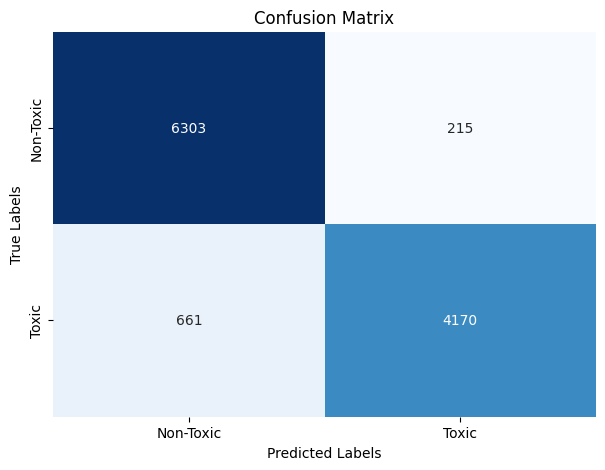

In [ ]:
plt.figure(figsize=(7,5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=["Non-Toxic", "Toxic"],
            yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
data = pd.read_csv("toxic-tweets-dataset/FinalBalancedDataset.csv", usecols=[1,2])[["tweet", "Toxicity"]]

train_data, test_data = train_test_split(data,
                                         test_size=0.995,
                                         random_state=37)


Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        55
           1       0.87      0.76      0.81        45

    accuracy                           0.84       100
   macro avg       0.85      0.83      0.84       100
weighted avg       0.84      0.84      0.84       100



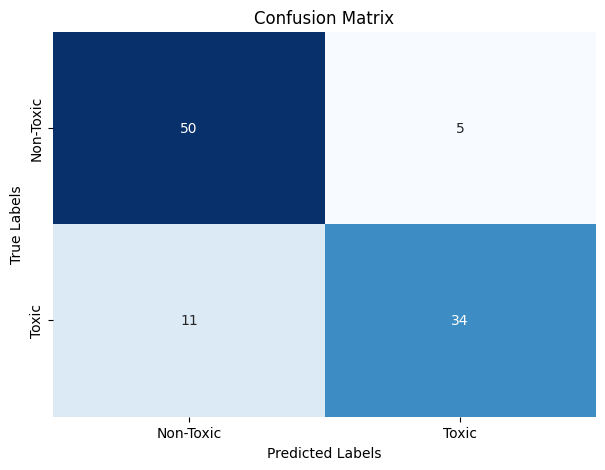

In [ ]:
# # Download data from Kaggle
# od.download("https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset")
# # Load the data
# data = pd.read_csv("toxic-tweets-dataset/FinalBalancedDataset.csv", usecols=[1,2])[["tweet", "Toxicity"]]

# Initialize the vectorizer and the classifier
vectorizer = TfidfVectorizer(stop_words='english')
# Fit the vectorizer on the training data
vectorizer.fit(train_data['tweet'])

clf = PassiveAggressiveClassifier(C=0.1, loss='hinge')
X_train_batch = vectorizer.transform(train_data['tweet'])
y_train_batch = train_data['Toxicity']
clf.fit(X_train_batch, y_train_batch)


# Separate the text and labels
test_data = test_data.sample(n=100)
texts = test_data['tweet'].apply(clean_text)
labels = test_data['Toxicity']

# Convert text to vectors
# X_test = np.array([get_bert_embedding(text) for text in texts])
X_test = vectorizer.transform(test_data['tweet'])
y_test = np.array(labels)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=["Non-Toxic", "Toxic"],
            yticklabels=["Non-Toxic", "Toxic"])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Data sample

In [ ]:
data.sample(5)

,tweet,Toxicity
38198,@jdickerson @ScottPelley @bobschieffer all rac...,1
41767,Hey ladies can i ask you a question ? Why do y...,1
31123,roxy's last day. lol. i'm still very much obse...,0
49555,RT @TerryisBetter: What faggot complained abou...,1
14708,quiet âmindfulâ learning revolution sweepi...,0


## Data cleaning

In [ ]:
data.tweet

0         @user when a father is dysfunctional and is s...
1        @user @user thanks for #lyft credit i can't us...
2                                      bihday your majesty
3        #model   i love u take with u all the time in ...
4                   factsguide: society now    #motivation
                               ...                        
56740    you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741    you've gone and broke the wrong heart baby, an...
56742    young buck wanna eat!!.. dat nigguh like I ain...
56743                youu got wild bitches tellin you lies
56744    ~~Ruffled | Ntac Eileen Dahlia - Beautiful col...
Name: tweet, Length: 56745, dtype: object

In [ ]:
data.tweet.sample(5)

23195    sometimes sad soppy gloopy nothing goes well s...
39780    girlfriend gotta accept fact hoes gone face bo...
18982    went boys really outside dancing around car li...
27741                                              tonight
33822                            trynna find bitch fat ass
Name: tweet, dtype: object

In [ ]:
data.tweet[0]

'father dysfunctional selfish drags kids dysfunction run'

## Real-time data from Reddit

In [ ]:
!pip install asyncpraw praw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 16.6 MB/s eta 0:00:00


### Playing with PRAW

In [ ]:
import praw
import asyncpraw
from google.colab import userdata

reddit = asyncpraw.Reddit(
    client_id=userdata.get("client_id"),
    client_secret=userdata.get("client_secret"),
    user_agent=userdata.get("user_agent"),
)

print(reddit.read_only)

True


In [ ]:
reddit = praw.Reddit(
    client_id=userdata.get("client_id"),
    client_secret=userdata.get("client_secret"),
    user_agent=userdata.get("user_agent"),
)

In [ ]:
subreddit = reddit.subreddit("redditdev")
for submission in subreddit.hot(limit=10):
    print(submission.title)
    # Output: the submission's title
    # print(submission.score)
    # Output: the submission's score
    # print(submission.id)
    # Output: the submission's ID
    # print(submission.url)
    # Output: the URL the submission points to or the submission's URL if it's a self post

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7cd7f52129b0>


Updating API user setting fields
Developer Data Protection Addendum (DPA) and updated Developer Terms
Facing "Blocked" Error When Trying to Submit a Post via Reddit API, Other Endpoints Work Fine
Searching all Reddit posts with API
Retrieveing a gallery's images accesses the contained images in random order. How can I obtain them in the order determined by OP?
How do I search for a post using praw?
Found an error in reddit. How to contact?
PRAW TimeOut Error
Is there a way to get all subreddits flair using PRAW ? 
How do you filter out posts based on whether they have a certain flair? (PRAW)


In [ ]:
for comment in reddit.subreddit("AskWomen").stream.comments(skip_existing=True):
    print(comment.body)
    break

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

KeyboardInterrupt: 

In [ ]:
import re
import praw
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from nltk.corpus import stopwords
import nltk

# Download stopwords
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# Reddit API credentials
REDDIT_CLIENT_ID = userdata.get("client_id")
REDDIT_CLIENT_SECRET = userdata.get("client_secret")
REDDIT_USER_AGENT = userdata.get("user_agent")

# Function to clean the text and remove stopwords
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and # from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    # Remove stopwords
    # text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

# Initialize the vectorizer and the classifier
vectorizer = TfidfVectorizer(stop_words='english')
clf = PassiveAggressiveClassifier(max_iter=1, random_state=42)

# Initialize a DataFrame to store training data
training_data = pd.DataFrame(columns=['text', 'label'])

# Connect to Reddit API
reddit = praw.Reddit(client_id=REDDIT_CLIENT_ID,
                     client_secret=REDDIT_CLIENT_SECRET,
                     user_agent=REDDIT_USER_AGENT)

# Function to stream comments from a subreddit
def stream_comments(subreddit_name, batch_size=10):
    subreddit = reddit.subreddit(subreddit_name)
    comment_stream = subreddit.stream.comments(skip_existing=False)

    batch = []
    for comment in comment_stream:
        try:
            comment_text = clean_text(comment.body)
            # For the sake of this example, we will label the comment as non-toxic (0)
            # In practice, you should have a way to label comments appropriately
            label = 0
            batch.append((comment_text, label))

            if len(batch) >= batch_size:
                yield batch
                batch = []
        except Exception as e:
            print(f'Error: {e}')

# Stream comments and perform incremental training
subreddit_name = 'technology'  # Use any specific subreddit if needed
for batch in stream_comments(subreddit_name, batch_size=10):
    batch_df = pd.DataFrame(batch, columns=['text', 'label'])
    X_train_batch = vectorizer.fit_transform(batch_df['text'])
    y_train_batch = batch_df['label']
    clf.partial_fit(X_train_batch, y_train_batch, classes=[0, 1])
    print(f'Trained on batch of {len(batch_df)} samples.')

# Example evaluation (in practice, use a separate, pre-labeled test dataset)
test_data = pd.DataFrame({
    'text': ["Sample comment text for testing"],  # Replace with actual test data
    'label': [0]  # Replace with actual labels
})

X_test = vectorizer.transform(test_data['text'])
y_test = test_data['label']
y_pred = clf.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Trained on batch of 10 samples.


ValueError: X has 104 features, but PassiveAggressiveClassifier is expecting 131 features as input.

In [ ]:
import re
import praw
import torch
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from nltk.corpus import stopwords
import nltk

# Download stopwords
# nltk.download('stopwords')
# stop_words = set(stopwords.words('english'))

# Reddit API credentials
REDDIT_CLIENT_ID = userdata.get("client_id")
REDDIT_CLIENT_SECRET = userdata.get("client_secret")
REDDIT_USER_AGENT = userdata.get("user_agent")

# Set up Reddit API connection
reddit = praw.Reddit(client_id=REDDIT_CLIENT_ID,
                     client_secret=REDDIT_CLIENT_SECRET,
                     user_agent=REDDIT_USER_AGENT)

# Load the pretrained BERT model and tokenizer for hate speech detection
model_name = "JungleLee/bert-toxic-comment-classification"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.eval()  # Set model to evaluation mode

# Define a function to predict labels using BERT
def predict_hate_speech(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()
    return prediction  # 1 for toxic, 0 for non-toxic

# Load the pretrained BERT model and tokenizer for embeddings
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.eval()  # Set model to evaluation mode

# Define a function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # Use the [CLS] token's embedding as the representation for the entire sequence
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

# Clean the text and remove stopwords
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    # text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

# Initialize the vectorizer and the classifier
vectorizer = TfidfVectorizer(stop_words='english')
clf = PassiveAggressiveClassifier(max_iter=1, random_state=42)

# Create a placeholder for test set data
test_data = []

# Stream and label comments from a subreddit, and update the model with partial_fit
def stream_and_train(subreddit_name, test_size=0.2, max_train_comments=10):
    subreddit = reddit.subreddit(subreddit_name)
    comment_stream = subreddit.stream.comments(skip_existing=False)

    for comment in comment_stream:
        try:
            cleaned_text = clean_text(comment.body)
            label = predict_hate_speech(cleaned_text)

            # Get BERT embedding for the cleaned text
            X_new = get_bert_embedding(cleaned_text)
            X_new = X_new.reshape(1, -1)  # Reshape for compatibility

            # Perform partial_fit on each new instance
            clf.partial_fit(X_new, [label], classes=[0, 1])

            # Store some data for the test set
            if len(test_data) < int(max_train_comments * test_size):
                test_data.append((cleaned_text, label))

            # Stop after a certain number of comments
            if len(test_data) + clf.n_iter_ >= max_train_comments:
                break
        except Exception as e:
            print(f'Error: {e}')

# Example usage: stream, label, and train on comments from the 'all' subreddit
subreddit_name = 'all'
stream_and_train(subreddit_name)

# Convert the test data into a DataFrame
test_df = pd.DataFrame(test_data, columns=['text', 'label'])

# Vectorize the test data
X_test = vectorizer.transform(test_df['text'])
y_test = test_df['label']

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

KeyboardInterrupt: 

In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer, TextClassificationPipeline

model_path = "JungleLee/bert-toxic-comment-classification"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)
# print(pipeline("You're a fucking nerd."))
text = "You're not a fucking nerd."
pipeline(text)

[{'label': 'toxic', 'score': 0.9998196959495544}]

In [ ]:
text = "You're good."
pipeline(text)[0]['label']

'non-toxic'

In [ ]:
def predict_hate_speech(text):
    prediction = pipeline(text)[0]['label']
    return 1 if prediction == 'toxic' else 0

In [ ]:
# Helper function to stream comments from a subreddit
def stream_comments(subreddit_name, batch_size=100):
    subreddit = reddit.subreddit(subreddit_name)
    comment_stream = subreddit.stream.comments()

    batch = []
    for comment in comment_stream:
        try:
            # Clean the incoming text
            comment_text = clean_text(comment.body)
            # Label the comment using the pretrained BERT model
            label = predict_hate_speech(comment_text)
            # Add the text and label to the current batch
            batch.append((comment_text, label))

            if len(batch) >= batch_size:
                yield batch
                batch = []

        except Exception as e:
            print(f'Error: {e}')


# Stream comments and perform incremental training
subreddit_name = 'all'
for num_rounds, batch in enumerate(stream_comments(subreddit_name, batch_size=100, rounds=10)):
    if num_rounds == rounds:
        break

    batch_texts = [item[0] for item in batch]
    batch_labels = [item[1] for item in batch]

    # Convert the batch of texts to BERT embeddings
    X_train_batch = np.array([get_bert_embedding(text) for text in batch_texts])
    y_train_batch = np.array(batch_labels)

    # Train the model on the current batch
    clf.partial_fit(X_train_batch, y_train_batch, classes=[0, 1])
    print(f'Trained on batch of {len(batch_texts)} samples.')

print('Training completed')